In [1]:
import glob, tqdm, time, os

# Custom tools
import sys
sys.path.append("../../")
import tools

from base import NSM
from base import create_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm

from matplotlib import rcParams
import pyro

import scipy.stats as S

from scvi import REGISTRY_KEYS

from torch.utils.tensorboard import SummaryWriter

Global seed set to 0


In [2]:
torch.randn(5)

tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
DATADIR = "../../data/GSE136148/"
SC_FILE = DATADIR + "sc.tsv"
BULK_FILE = DATADIR + "bulk.tsv"

sc.settings.set_figure_params(dpi=60, facecolor='white', figsize=(8,8))

In [5]:
adata = sc.read_csv(SC_FILE, delimiter="\t")

# preprocessing and QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# sc.pp.filter_genes(adata, min_counts=1000)

adata.var

,n_cells
RP11.34P13.7,27
FO538757.2,412
AP006222.2,1136
RP4.669L17.2,31
RP4.669L17.10,14
...,...
AC007325.4,680
AC007325.2,5
AL354822.1,29
AC004556.1,7


In [6]:
adata.layers["counts"] = adata.X.copy()

In [7]:
ncounts = sc.pp.normalize_total(adata, layer="counts", inplace=False)["X"]
adata.var["cv2"] = (ncounts.std(0)/ncounts.mean(0))**2
adata.var["mu"] = ncounts.mean(0)
logx = np.log(adata.var["mu"])
logy = np.log(adata.var["cv2"])

In [8]:
fit = np.poly1d(np.polyfit(logx, logy, 2))

adata.var["residual"] = fit(logx) - logy
adata.var["residual_dx"] = np.abs(adata.var["residual"])
adata.var["outlier"] = adata.var["residual_dx"] > 1.0

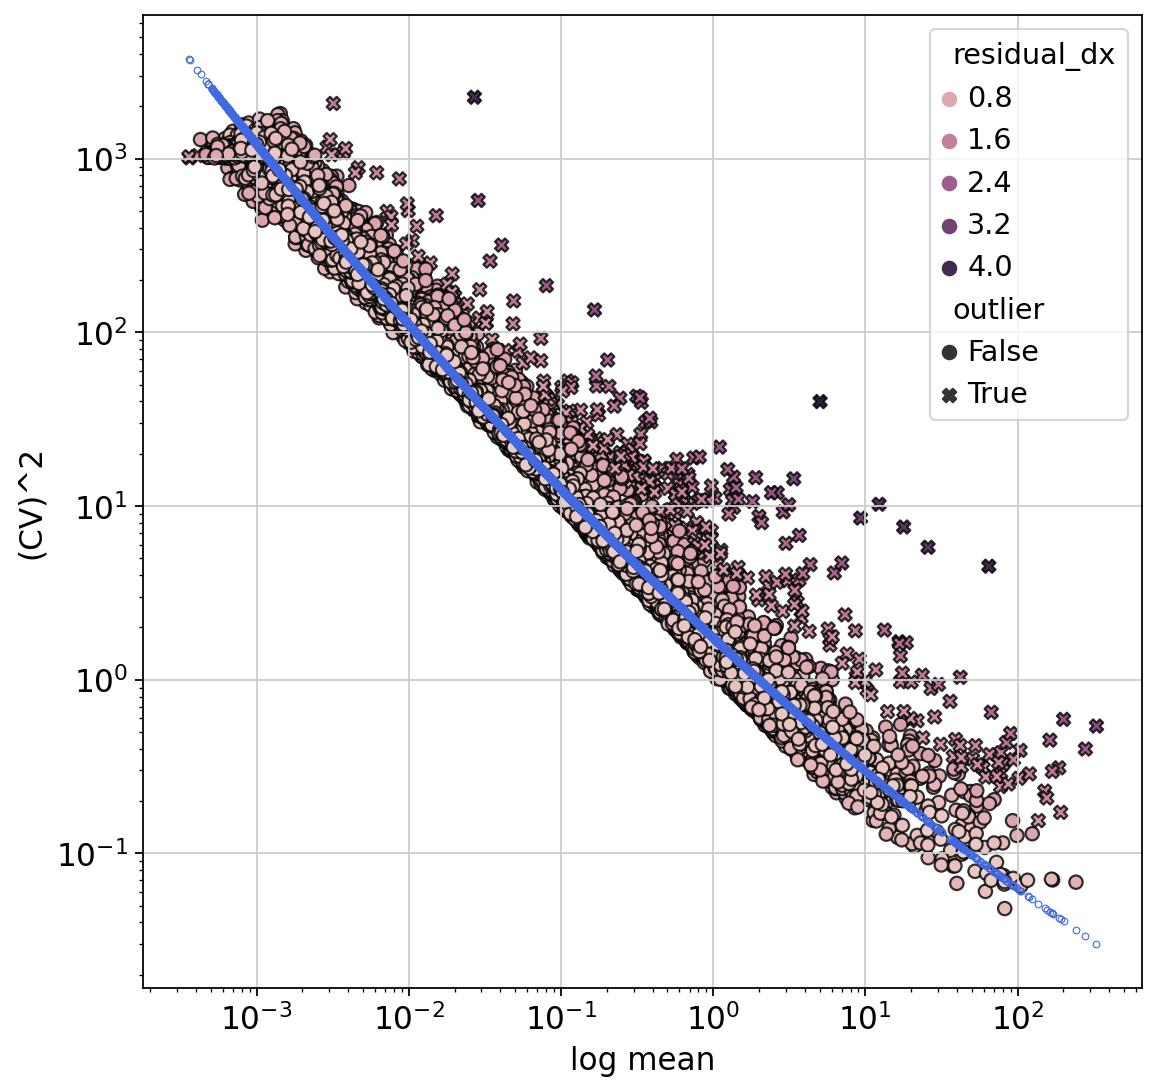

In [9]:
f, ax = plt.subplots(figsize=(8,8), dpi=80)
sns.scatterplot(
    data=adata.var, x="mu", y="cv2", hue="residual_dx", style="outlier",
    edgecolor=(0,0,0,0.8), color=(1,1,1,0), linewidth=1, ax=ax
)

ax.plot(
    adata.var["mu"], np.exp(fit(logx)),
    ".", markeredgecolor="royalblue", markeredgewidth=0.5, color=(1,1,1,0),
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("log mean")
ax.set_ylabel("(CV)^2")
plt.show()

In [10]:
bulk_adata = sc.read_csv(BULK_FILE, delimiter="\t")
bulk_adata.var_names_make_unique()
bulk_adata

AnnData object with n_obs × n_vars = 1 × 58387

In [11]:
common_genes = list(set(bulk_adata.var.index.values).intersection(set(adata.var.index.values)))
bulk_adata = bulk_adata[:,common_genes].copy()
adata = adata[:,common_genes].copy()

In [12]:
# sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor="seurat_v3")
bulk_adata = bulk_adata[:,adata.var.index.values].copy()
bulk_adata.layers["counts"] = bulk_adata.X.copy()

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# sc.pp.normalize_total(bulk_adata)
# sc.pp.log1p(bulk_adata)

In [14]:
sc.settings.figdir

PosixPath('figures')

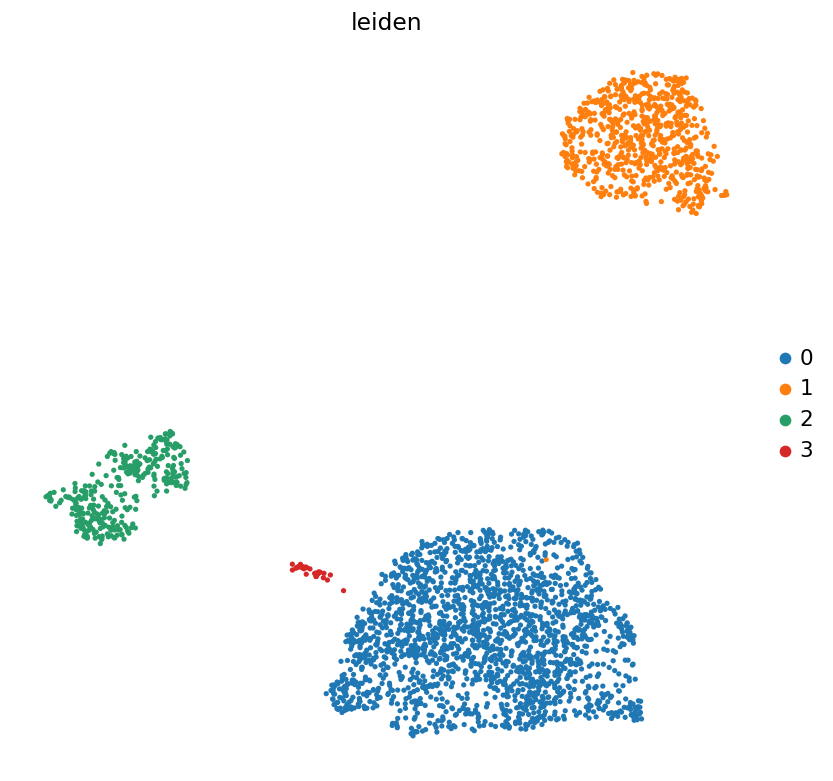

In [15]:
sc.settings.set_figure_params(dpi=60, facecolor='white', figsize=(8,8))
sc.tl.pca(adata)
sc.pp.neighbors(adata, random_state=0)
sc.tl.umap(adata, min_dist=0.5)
sc.tl.leiden(adata, random_state=0, resolution=0.1)
sc.pl.umap(adata,  color=["leiden"], ncols=2, frameon=False)

In [16]:
adata = adata[adata.obs["leiden"] != '3',:].copy()

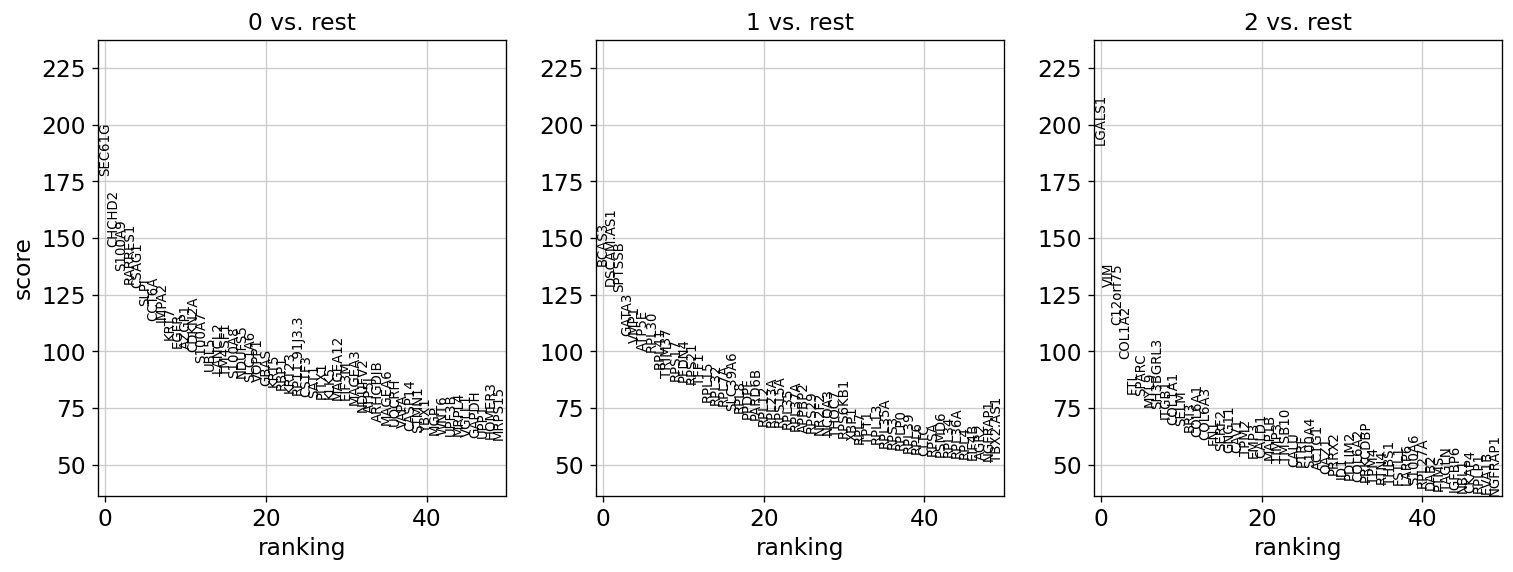

In [17]:
sc.settings.set_figure_params(dpi=60, facecolor='white', figsize=(5,5))
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=True)

In [32]:
marker_genes = list(sum(adata.uns["rank_genes_groups"]["names"].tolist(),()))
len(marker_genes)

55905

In [121]:
adata.uns["rank_genes_groups"]

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('SEC61G', 'BCAS3', 'LGALS1'), ('CHCHD2', 'DSCAM.AS1', 'VIM'),
            ('S100A9', 'SPTSSB', 'C12orf75'), ...,
            ('RPL34', 'FXYD5', 'TPD52L1'), ('NGFRAP1', 'S100A4', 'TSTD1'),
            ('RPL37A', 'GPX1', 'S100A14')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O')]),
 'scores': rec.array([(177.33781 ,  137.68393 ,  191.02644),
            (146.06746 ,  129.11499 ,  128.51523),
            (135.52039 ,  126.1575  ,  111.68416), ...,
            (-79.00358 , -102.96251 ,  -84.84162),
            (-86.1877  , -107.495964,  -87.92342),
            (-92.337166, -115.479454, -100.01366)],
           dtype=[('0', '<f4'), ('1', '<f4'), ('2', '<f4')]),
 'pvals': rec.array([(0., 0., 0.00000000e+000), (0., 0., 0.00000000e+000),
            (0., 0., 2.42111907e-287), ..., (0., 0., 1.73663989e-295),
     

In [120]:
adata.var.loc[:,adata.var.columns.str.contains("ct_marker_")]

,ct_marker_0,ct_marker_2,ct_marker_1,ct_marker_mu,ct_marker_max,ct_marker_min
LINC00518,3.636037,-3.633167,-3.634491,-1.210540,3.636037,-3.634491
RP1.23E21.2,0.583515,-1.984660,-0.078927,-0.493358,0.583515,-1.984660
PLA2G2F,4.722782,-4.716288,-4.719282,-1.570929,4.722782,-4.719282
EPN2,-12.126349,4.148349,9.788785,0.603595,9.788785,-12.126349
RP11.400N13.3,-3.084779,3.113379,-3.077441,-1.016280,3.113379,-3.084779
...,...,...,...,...,...,...
CDKN2B.AS1,-0.164915,-8.079978,2.624591,-1.873434,2.624591,-8.079978
MIS12,-4.652453,-1.027634,5.722821,0.014245,5.722821,-4.652453
RP4.594I10.3,0.144891,3.654043,-7.864787,-1.355284,3.654043,-7.864787
IFFO2,1.609805,-0.721130,-1.303152,-0.138159,1.609805,-1.303152


In [75]:
list(mapping['0'].keys())[:10]

['SEC61G',
 'CHCHD2',
 'S100A9',
 'RARRES1',
 'CSAG1',
 'SLPI',
 'CCT6A',
 'IMPA2',
 'KRT7',
 'EGFR']

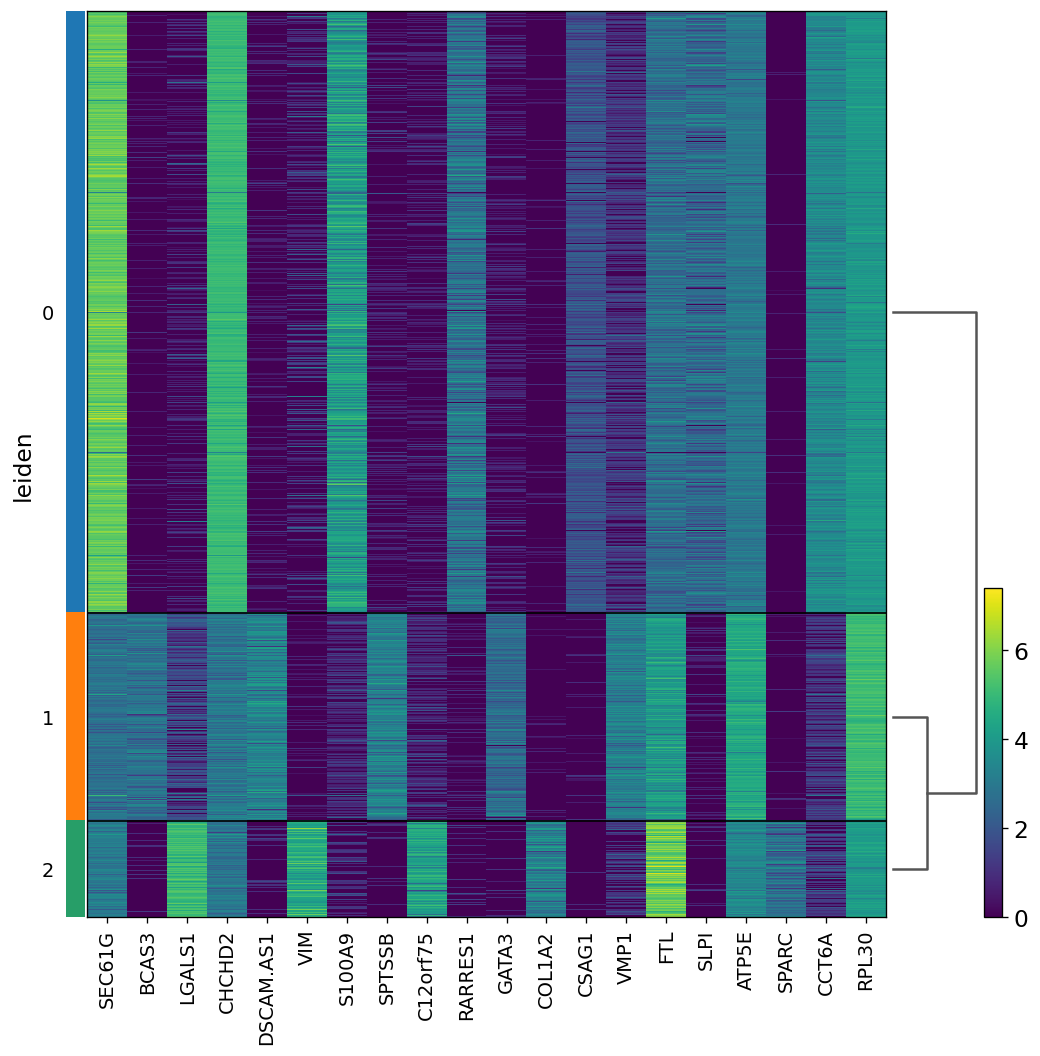

In [37]:
sc.pl.heatmap(adata, marker_genes[:20], groupby="leiden", cmap="viridis", dendrogram=True, figsize=(10,10))

In [47]:
X, Y, pseudo = create_dataset(adata, bulk_adata, genes=None, res_limits=None)

In [48]:
# Y = pseudo

In [49]:
n_cell_types = 3
n_genes = Y.shape[-1]

In [55]:
Y[torch.randperm(Y.shape[0])[:]]

tensor([14979.7461,   137.0004,   774.2523,  ...,   168.7998,     0.0000,
           29.0000])

In [54]:
Y

tensor([1260.0006,    0.0000,    0.0000,  ..., 1842.0354,  217.8299,
           0.0000])

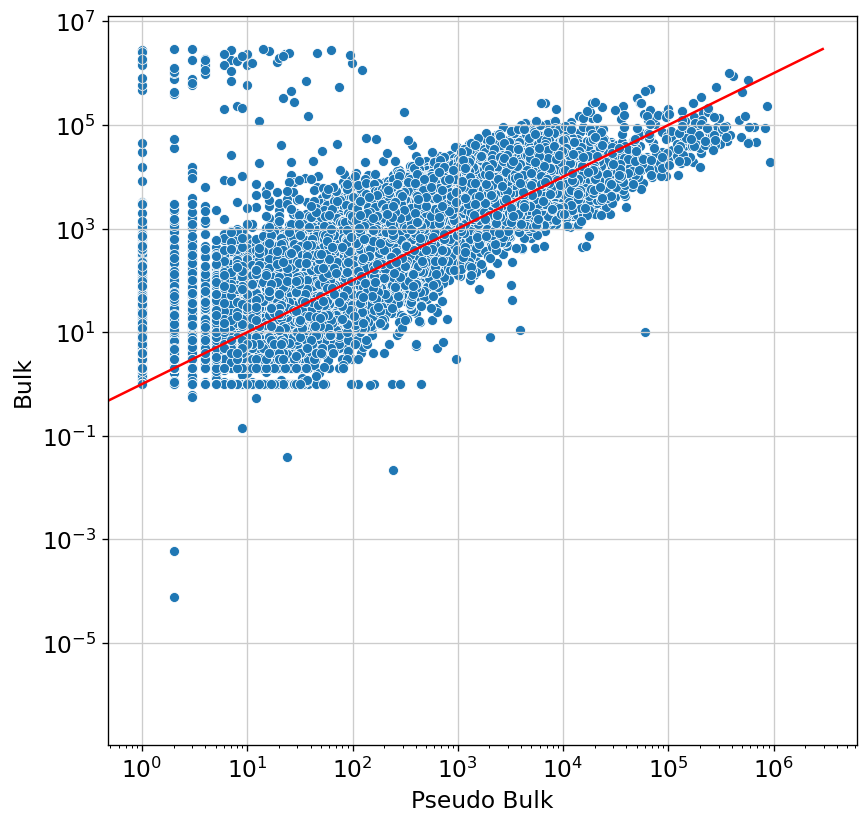

In [57]:
f, ax = plt.subplots(1, 1, figsize=(8,8))
sns.scatterplot(x=pseudo, y=Y, ax = ax)
ax.plot([0,Y.max()], [0,Y.max()], label="y=x", c="red")
# ax.set_xlim(0, 2000)
# ax.set_ylim(0, 2000)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Pseudo Bulk")
ax.set_ylabel("Bulk")
plt.savefig("Bulk_pseudo.png")
plt.show()

In [25]:
loc = torch.empty(n_genes, n_cell_types)
scale = torch.empty(n_genes, n_cell_types)

for cell_type in range(n_cell_types):
    loader = torch.utils.data.DataLoader(X[cell_type], batch_size=32)

    loc[:,cell_type] = torch.tensor(X[cell_type].mean(0))
    scale[:,cell_type]  = torch.tensor(X[cell_type].std(0))

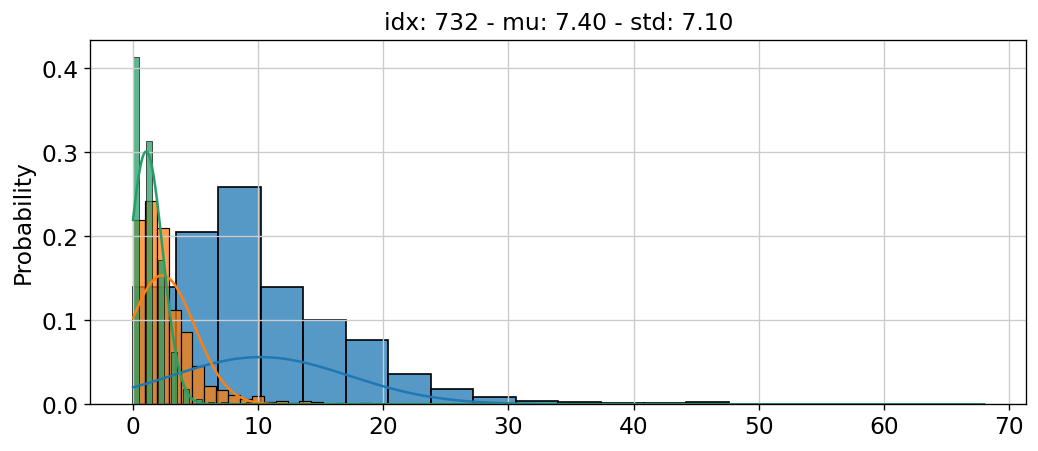

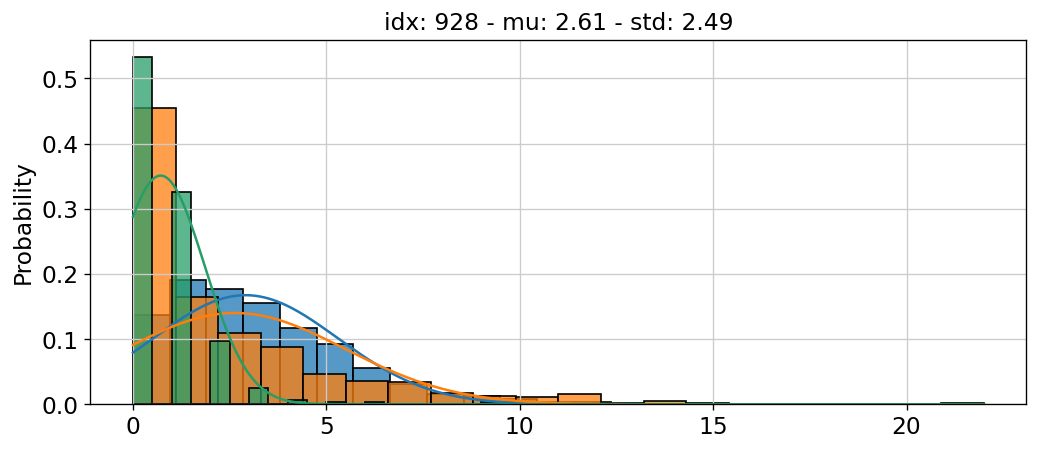

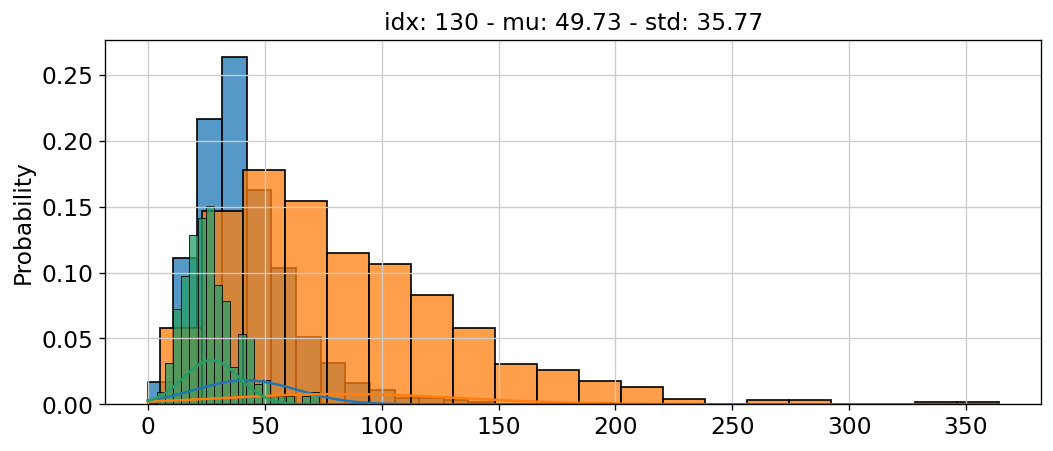

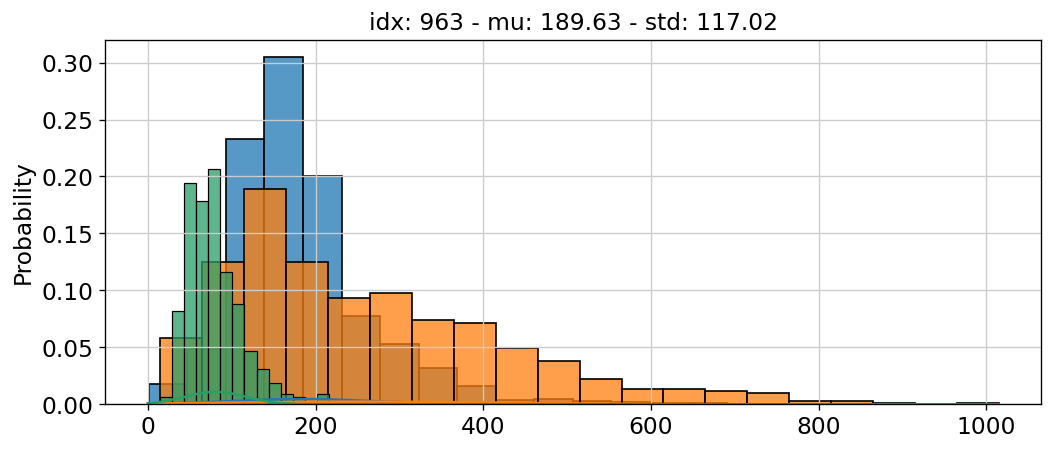

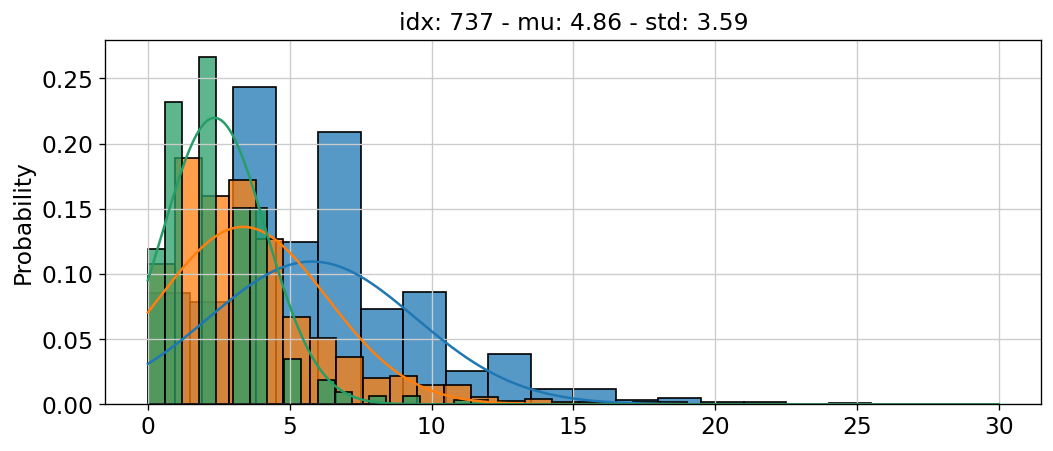

In [26]:
for i, gene in enumerate(torch.randperm(n_genes)[:5]):
    f, ax = plt.subplots(1, 1, figsize=(10,4))
    for cell_type in range(n_cell_types):
        sns.histplot(X[cell_type][:,gene], bins=20, stat="probability", ax=ax, color=sns.color_palette()[cell_type])
        # plt.hist(X[cell_type][:,gene], bins=20, density=True, alpha=0.5, color=sns.color_palette()[cell_type])
        xx = torch.linspace(0, max(X[0][:,gene].max(), X[1][:,gene].max(), X[2][:,gene].max()), 1000)
        d = D.Normal(loc[gene, cell_type], torch.max(torch.tensor(0.000001), scale[gene, cell_type]))
        sns.lineplot(x=xx, y=d.log_prob(xx).exp().detach(), ax=ax, color=sns.color_palette()[cell_type])
        c = torch.concat(X)[:,gene]
        ax.set_title(f"idx: {gene.item()} - mu: {c.mean().item():.2f} - std: {c.std().item():.2f}")
    plt.savefig("fit.pdf")
    plt.show()

In [27]:
pbar = tqdm.tqdm(range(10000))
model = NSM(loc, scale)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

for i in pbar:
    optim.zero_grad()
    loss = model(Y)
    loss.backward()
    optim.step()
    if i % 50 == 0:
        pbar.set_postfix({"loss":f"{loss.item():.1f}", "props" :D.Categorical(torch.abs(model.weights.data)).probs, "lib_size": f"{model.lib_size.data.exp():.1f}"})

pbar.set_postfix({"loss":f"{loss.item():.1f}", "props" :D.Categorical(torch.abs(model.weights.data)).probs, "lib_size": f"{model.lib_size.data.exp():.1f}"})
    

100%|██████████| 10000/10000 [00:04<00:00, 2075.14it/s, loss=4540.0, props=tensor([0.3711, 0.6042, 0.0247]), lib_size=6127.0]


In [28]:
P = torch.tensor([X[0].shape[0], X[1].shape[0], X[2].shape[0]], dtype=float)
(P / P.sum(), P.sum())

(tensor([0.6639, 0.2295, 0.1066], dtype=torch.float64),
 tensor(2993., dtype=torch.float64))

In [29]:
d = model.get_distribution(model.lib_size, model.weights.abs())

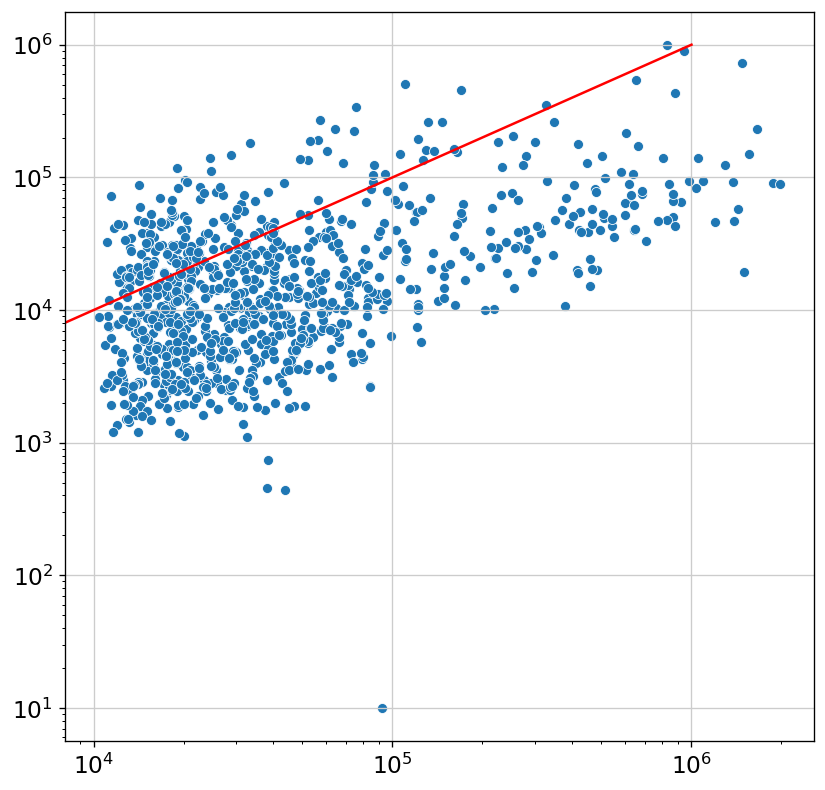

In [30]:
f, ax = plt.subplots(1, 1, figsize=(8,8))
sns.scatterplot(x=d.mean.detach(), y=Y, ax = ax)
ax.plot([0,Y.max()], [0,Y.max()], label="y=x", c="red")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()